<a href="https://colab.research.google.com/github/vienskaz/ECG-CNN/blob/main/leakyEKG_GANfourldim50_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import layers, models
import seaborn as sns
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense


In [3]:
mit_test_data = pd.read_csv('/content/drive/MyDrive/ecg/mitbih_test.csv', header=None)
mit_train_data = pd.read_csv('/content/drive/MyDrive/ecg/mitbih_train.csv', header=None)

X_train = mit_train_data.iloc[:, :-1].values
y_train = mit_train_data.iloc[:, -1].values
X_test = mit_test_data.iloc[:, :-1].values
y_test = mit_test_data.iloc[:, -1].values

normal = pd.read_csv('/content/drive/MyDrive/ecg/ptbdb_normal.csv', header=None)
abnormal = pd.read_csv('/content/drive/MyDrive/ecg/ptbdb_abnormal.csv', header=None)
X_normal = normal.iloc[:, :-1].values
y_normal = np.zeros(X_normal.shape[0])
X_abnormal = abnormal.iloc[:, :-1].values
y_abnormal = np.ones(X_abnormal.shape[0])

X = np.concatenate([X_normal, X_abnormal], axis=0)
y = np.concatenate([y_normal, y_abnormal], axis=0)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
X = X.reshape((X.shape[0], X.shape[1], 1))

Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

In [4]:
def moving_average_filter(signal, window_size=5):
    filtered=[]
    for data in signal:
      filtered_ecg = np.convolve(data.flatten(), np.ones(window_size) / window_size, mode='same')
      filtered.append(filtered_ecg)
    return np.array(filtered)


In [5]:
two = []
three = []
four = []
five = []

for i in range(len(Y_train)):
    if np.array_equal(Y_train[i], [0.0, 1.0, 0.0, 0.0, 0.0]):
        two.append(X_train[i])
    elif np.array_equal(Y_train[i], [0.0, 0.0, 1.0, 0.0, 0.0]):
        three.append(X_train[i])
    elif np.array_equal(Y_train[i], [0.0, 0.0, 0.0, 1.0, 0.0]):
        four.append(X_train[i])
    elif np.array_equal(Y_train[i], [0.0, 0.0, 0.0, 0.0, 1.0]):
        five.append(X_train[i])




In [6]:
np.array(two)
np.array(three)
np.array(four )
np.array(five )

array([[[0.71260995],
        [0.62903225],
        [0.52785921],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[1.        ],
        [0.4848485 ],
        [0.54166669],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.58404559],
        [0.5       ],
        [0.42450142],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       ...,

       [[0.90612245],
        [0.62448978],
        [0.59591836],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.85822785],
        [0.64556962],
        [0.84556961],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.90150636],
        [0.84588647],
        [0.80069524],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]]])

In [ ]:
print(len(two))
print(len(three))
print(len(four))
print(len(five))

2223
5788
641
6431


In [7]:
two = moving_average_filter(two)
three = moving_average_filter(three)
four = moving_average_filter(four)
five = moving_average_filter(five)

In [ ]:
print(two[0].shape)

(187,)


In [8]:
def build_discriminator(n=187):
    inps = layers.Input(shape=(n,))
    x = Dense(512,  activation=keras.layers.LeakyReLU(alpha=0.02))(inps)
    x = Dense(512, activation=keras.layers.LeakyReLU(alpha=0.02))(x)
    x = Dense(256, activation=keras.layers.LeakyReLU(alpha=0.02))(x)
    outs = Dense(1, activation='sigmoid')(x)
    model = models.Model(inps, outs, name='discriminator')
    return model

# Generator definition with the correct activation function


def build_generator(latent_dim=50, output_shape=(187, 1)):
    inps = layers.Input(shape=(latent_dim,))
    x = Dense(256, activation=keras.layers.LeakyReLU(alpha=0.02))(inps)
    x = Dense(256, activation=keras.layers.LeakyReLU(alpha=0.02))(x)
    outs = Dense(187, activation='tanh')(x)
    model = models.Model(inps, outs, name='generator')
    return model



discriminator = build_discriminator()
generator = build_generator(latent_dim=50)
print(discriminator.summary())
print(generator.summary())

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 187)]             0         
                                                                 
 dense (Dense)               (None, 512)               96256     
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 490497 (1.87 MB)
Trainable params: 490497 (1.87 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model: "gene

In [9]:
class GAN(keras.Model):

    def __init__(self, disc, gen, latent_dim=50):
        super(GAN, self).__init__()
        self.discriminator = disc
        self.generator = gen
        self.latent_dim = latent_dim

    def compile(self, optD, optG, loss_fn):
        super(GAN, self).compile()
        self.optD = optD
        self.optG = optG
        self.loss_fn = loss_fn

    def train_step(self, real_data):
        if isinstance(real_data, tuple):
            real_data = real_data[0]

        bs = tf.shape(real_data)[0]
        z = tf.random.normal(shape=(bs, self.latent_dim))
        fake_data = self.generator(z)

        combined_data = tf.concat([real_data, fake_data], axis=0)
        labels = tf.concat([tf.ones((bs, 1)), tf.zeros((bs, 1))], axis=0)

        with tf.GradientTape() as tape:
            preds = self.discriminator(combined_data)
            d_loss = self.loss_fn(labels, preds)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.optD.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        misleading_labels = tf.ones((bs, 1))
        z = tf.random.normal(shape=(bs, self.latent_dim))

        with tf.GradientTape() as tape:
            fake_preds = self.discriminator(self.generator(z))
            g_loss = self.loss_fn(misleading_labels, fake_preds)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.optG.apply_gradients(zip(grads, self.generator.trainable_weights))

        return {"d_loss": d_loss, "g_loss": g_loss}

gan = GAN(discriminator, generator)

gan.compile(
    optD=keras.optimizers.Adam(learning_rate=0.0001),
    optG=keras.optimizers.Adam(learning_rate=0.001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)


In [10]:
def show_samples(epoch, generator, data, n=187, l_dim=50):
  generated_points_list=[]
  if epoch % 100 == 0:
    z = tf.random.normal(shape=(n, l_dim))
    generated_data = generator(z)
    generated_points_list.append(generated_data)
    plt.plot(generated_data)
    plt.show()


Epoch 1/100
20/21 [===========================>..] - ETA: 0s - d_loss: 0.1959 - g_loss: 2.2909

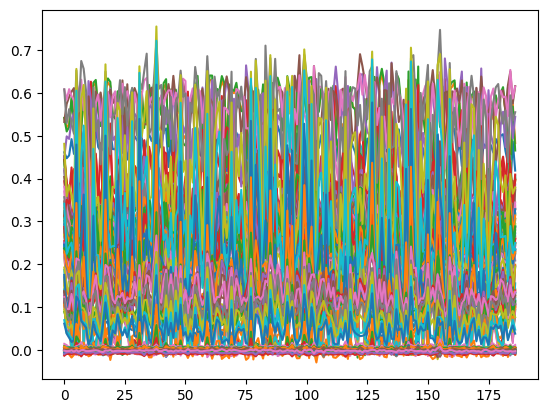

21/21 [==============================] - 1s 50ms/step - d_loss: 0.2026 - g_loss: 2.4297
Epoch 2/100
21/21 [==============================] - 0s 13ms/step - d_loss: 0.2070 - g_loss: 3.8218
Epoch 3/100
21/21 [==============================] - 0s 11ms/step - d_loss: 0.2194 - g_loss: 3.8163
Epoch 4/100
21/21 [==============================] - 0s 11ms/step - d_loss: 0.1674 - g_loss: 2.9431
Epoch 5/100
21/21 [==============================] - 0s 12ms/step - d_loss: 0.3310 - g_loss: 2.6949
Epoch 6/100
21/21 [==============================] - 0s 13ms/step - d_loss: 0.2812 - g_loss: 3.0421
Epoch 7/100
21/21 [==============================] - 0s 11ms/step - d_loss: 0.1918 - g_loss: 2.6798
Epoch 8/100
21/21 [==============================] - 0s 11ms/step - d_loss: 0.2305 - g_loss: 2.3523
Epoch 9/100
21/21 [==============================] - 0s 12ms/step - d_loss: 0.2185 - g_loss: 2.2535
Epoch 10/100
21/21 [==============================] - 0s 12ms/step - d_loss: 0.2092 - g_loss: 2.4711
Epoch 11/10

In [21]:
cbk = keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch,logs: show_samples(epoch, gan.generator, four))
%time hist = gan.fit(four, epochs=100, callbacks=[cbk], verbose=True)
gan.save_weights('/content/drive/MyDrive/ecg/architektura3/four2700epok50latentdimleakyrelu')


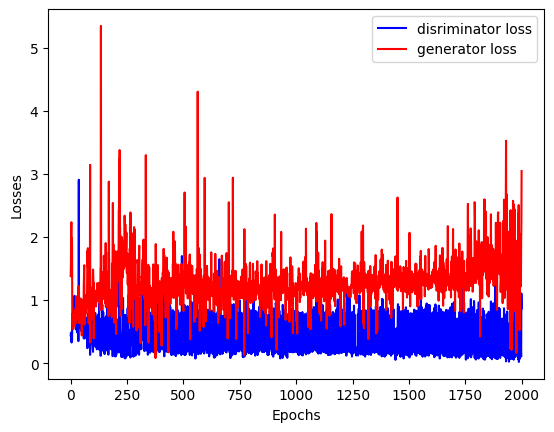

In [12]:
plt.plot(hist.history['d_loss'], color='blue', label='disriminator loss')
plt.plot(hist.history['g_loss'], color='red', label='generator loss')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend()

In [ ]:
gan.load_weights('/content/drive/MyDrive/ecg/architektura3/four2000epok50latentdim')

WAGI DLA 2

In [22]:
def do_data(nums):
    result = []
    latent_dim = 50
    num_samples_to_generate = 1

    for i in range(nums):
        # Generate new set of noise for each iteration
        latent_points = tf.random.normal(shape=(num_samples_to_generate, latent_dim))

        # Use the trained generator to generate data
        generated_data = generator(latent_points)

        # Squeeze the batch dimension, leaving (187, 1)
        generated_data = tf.squeeze(generated_data, axis=0)

        # Convert the TensorFlow tensor to a NumPy array
        generated_data_np = generated_data.numpy()

        # Add the generated data to the result list
        result.append(generated_data_np)

    # Convert the list to a NumPy array
    return np.array(result)

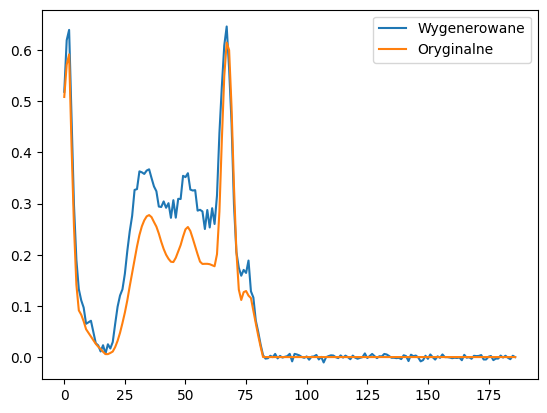

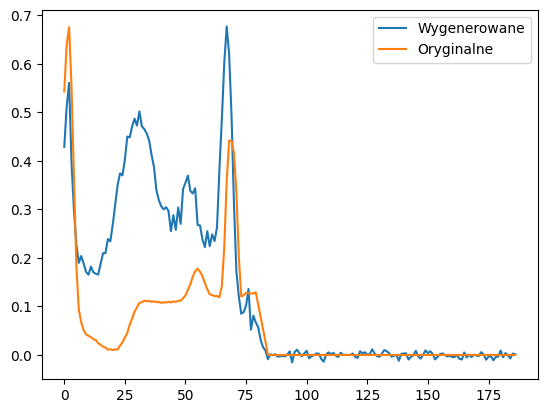

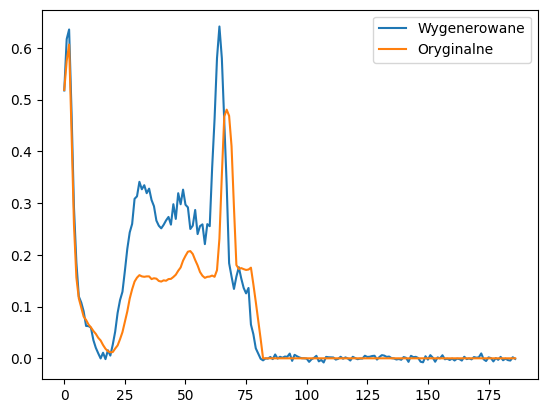

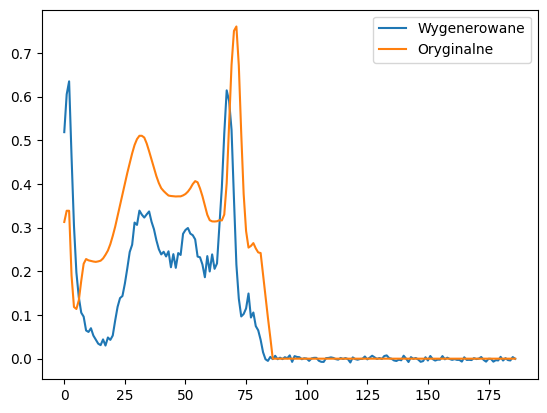

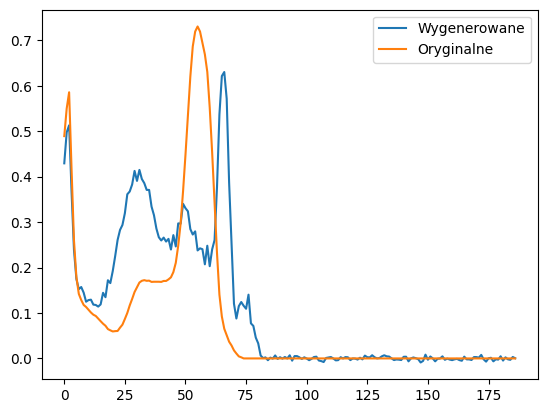

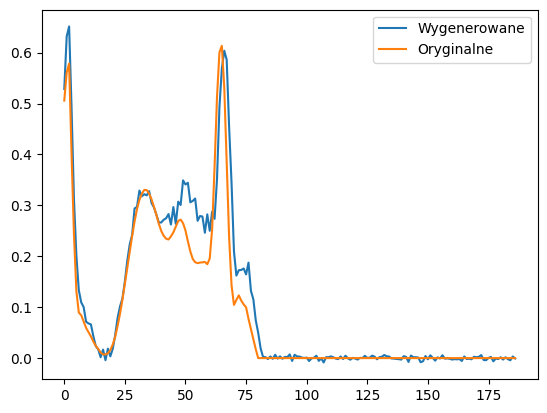

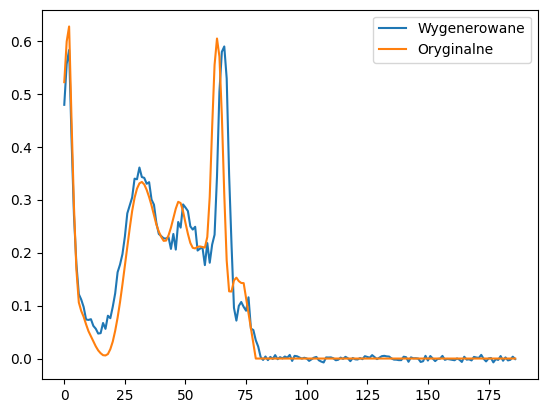

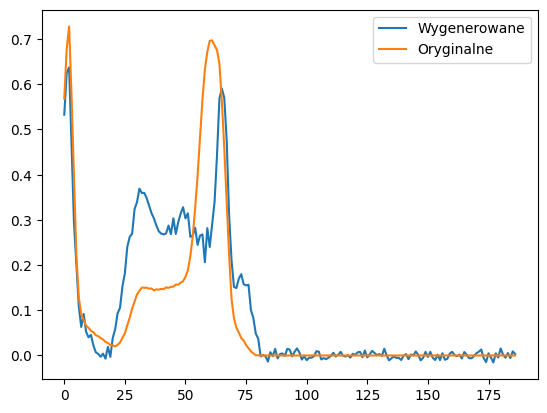

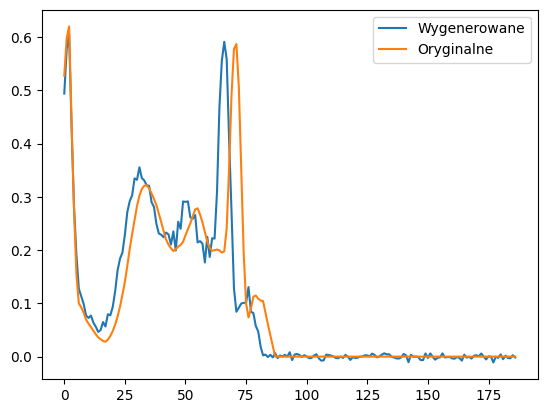

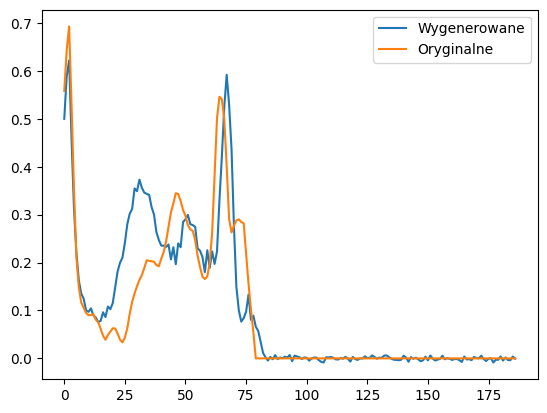

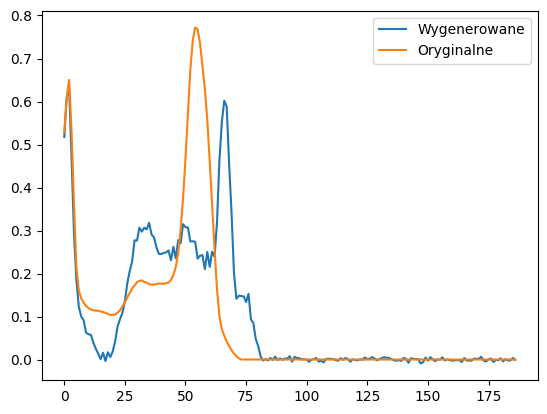

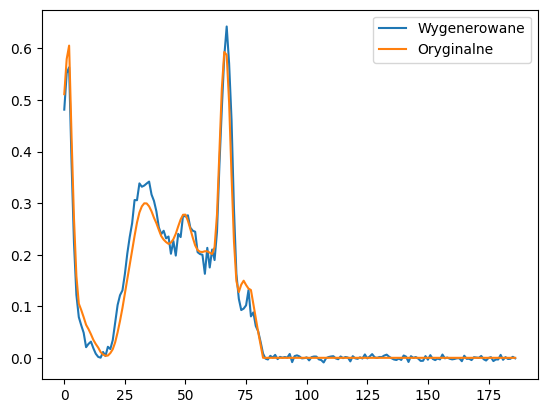

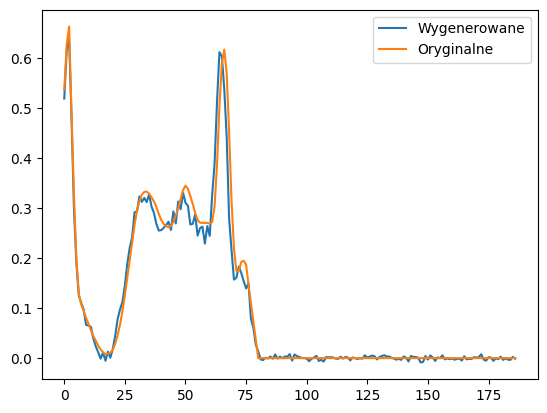

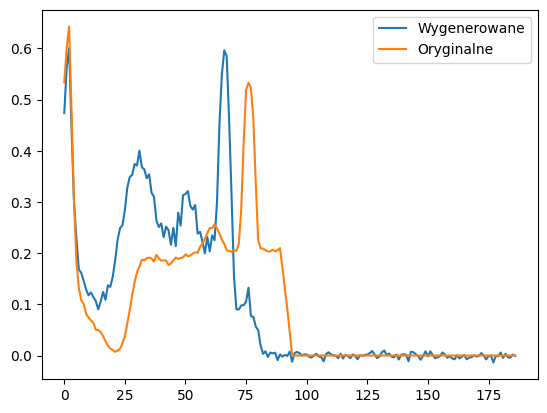

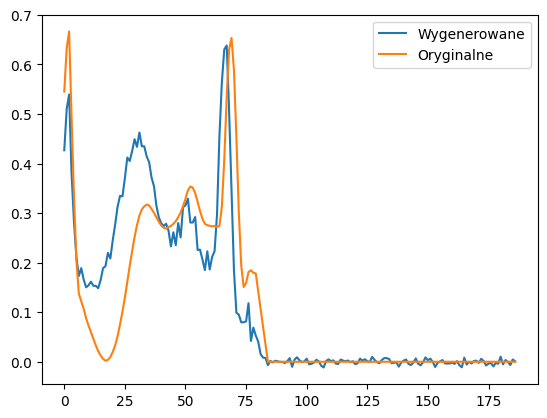

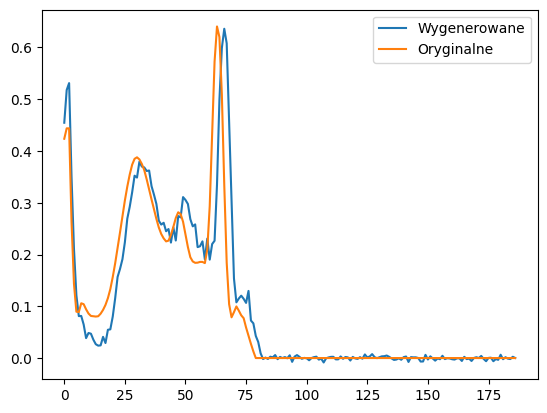

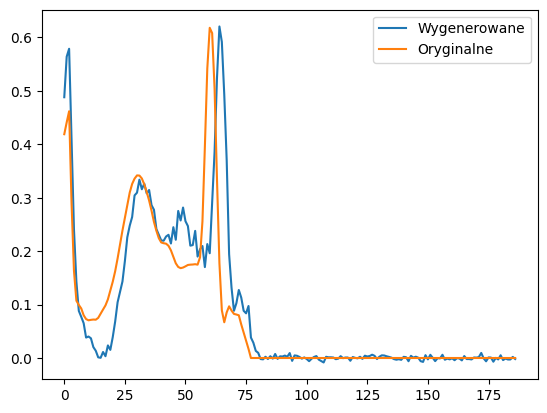

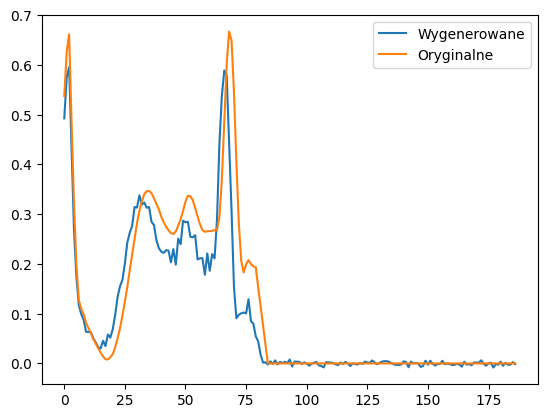

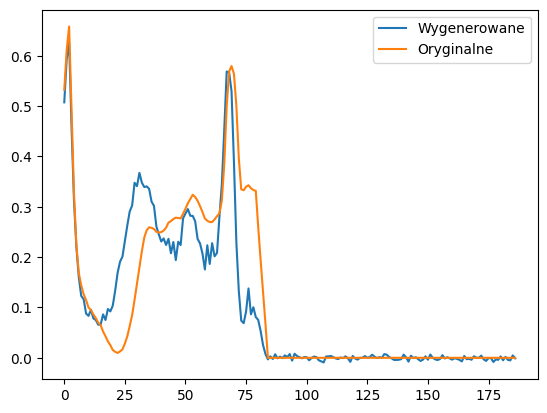

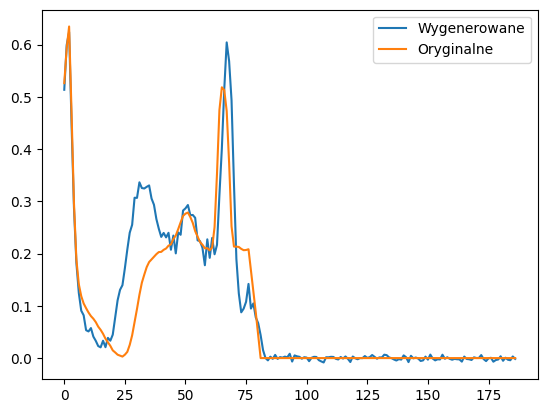

In [23]:
fours=do_data(20)

for i in range(len(fours)):
    plt.figure()
    plt.plot(fours[i], label='Wygenerowane')
    plt.plot(four[i], label='Oryginalne')

    # Dodanie legendy do wykresu
    plt.legend()

    # Wyświetlenie wykresu
    plt.show()

In [ ]:
from google.colab import files
fours=do_data(5000-len(four))
np.savetxt('fours.csv', fours, delimiter=',')

files.download('fours.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(len(four))
print(5000-len(four))

641
4359


In [ ]:
loaded_array = np.loadtxt('fours.csv', delimiter=',')

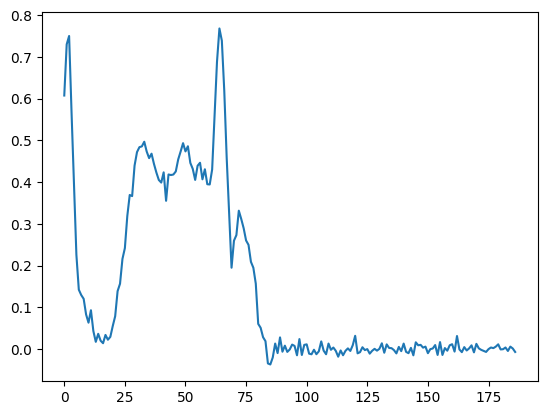

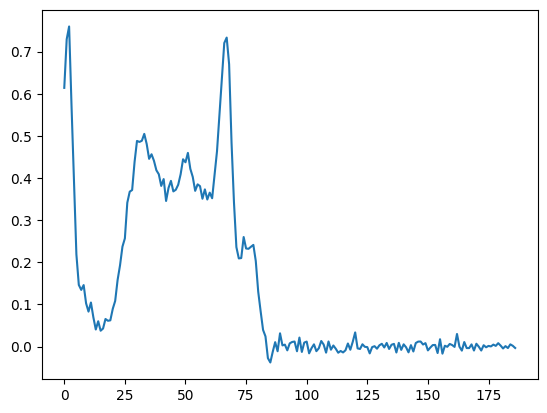

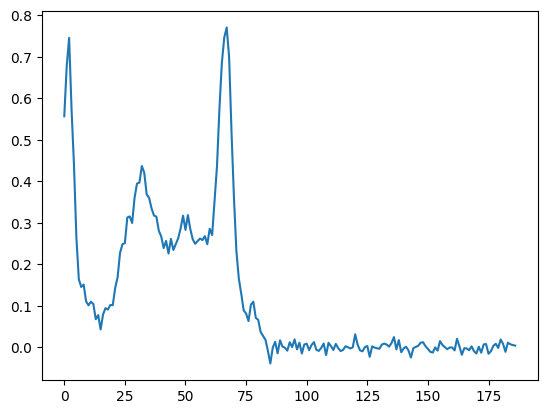

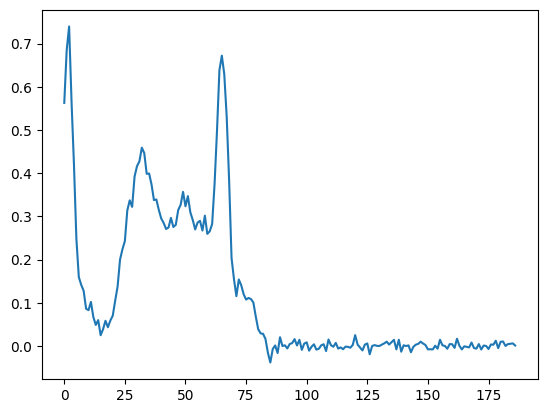

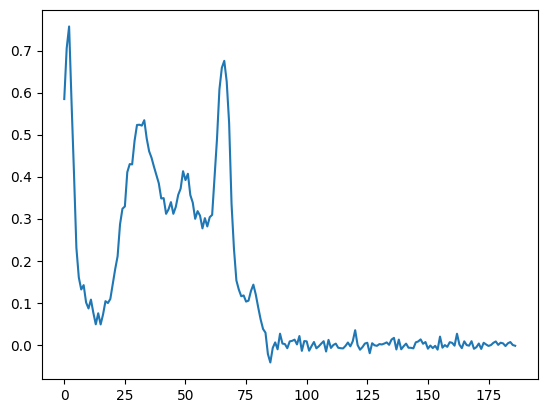

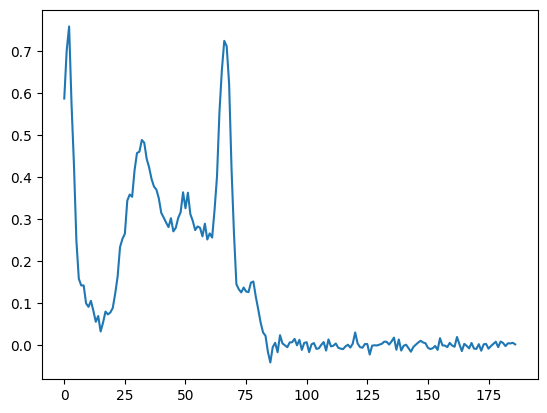

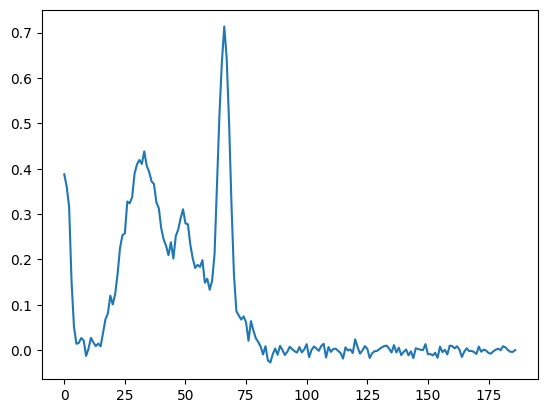

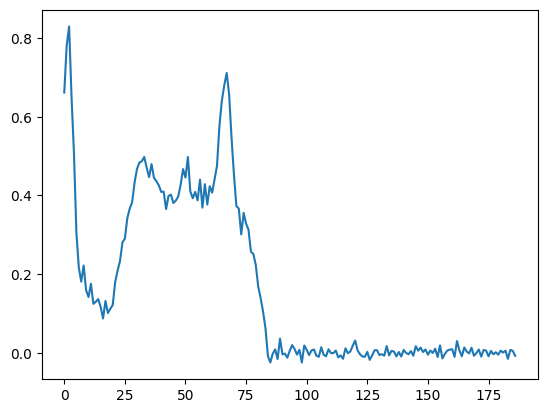

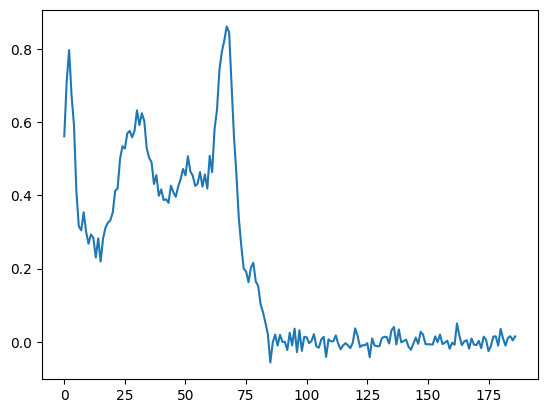

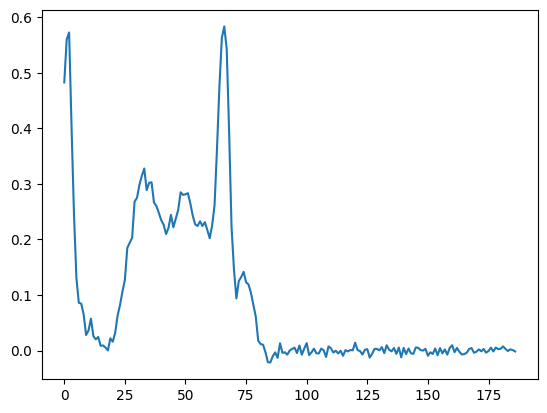

In [ ]:
for i in range(10):
    plt.figure()
    plt.plot(loaded_array[i], label='Wygenerowane')